#  chap2. 서울시 범죄 현황 분석

강남 3구가 체감 안전도가 높다는 기사를 검증하기.  
그 방법으로 서울시 구별 범죄 발생과 그 검거율을 지표로 사용.

## pandas를 이용해 데이터 정리하기

In [1]:
import numpy as np
import pandas as pd

In [2]:
crime_anal_police = pd.read_csv('../data/02. crime_in_Seoul.csv', thousands=',',
                               encoding='euc-kr')
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


crime_anal_police에는 살인,강도,강간,절도,폭력이라는 5대 범죄에 대해 발행 건수와 검거 건수 데이터를 가지고 있음.  

문제가 발생. 강남 3구가 안전한지 확인하려는 것인데 데이터가 관서별로 되어 있음.  
이 경찰서 목록을 소속 구별로 변경해야 함.  
그러기 위해 먼저 경찰서 이름으로 구 정보를 알아내야 함.

## 지도 정보를 얻을 수 있는 Google Maps

Google Map Geocoding API에서 키를 생성하고, 터미널에 googltmaps를 설치

```
pip install googlemaps
```

## Google Maps를 이용해서 주소와 위도, 경도 정보 얻기

In [3]:
import googlemaps

In [8]:
import json
import os

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
CONF_DIR = os.path.join(BASE_DIR, '.secret')
CONF_FILE = json.loads(open(os.path.join(CONF_DIR, 'key.json')).read())

gmaps_key = CONF_FILE['google']['gmaps_key']
gmaps = googlemaps.Client(key=gmaps_key)

Google Maps를 사용해서 '서울중부경찰서'라는 단어를 검색.  
`formatted_address` 항목에 주소가 나오고, lng, lat에서 위도와 경도도 확인이 가능.

In [9]:
gmaps.geocode('서울중부경찰서', language='ko')

[{'address_components': [{'long_name': '２７',
    'short_name': '２７',
    'types': ['premise']},
   {'long_name': '수표로',
    'short_name': '수표로',
    'types': ['political', 'sublocality', 'sublocality_level_4']},
   {'long_name': '을지로동',
    'short_name': '을지로동',
    'types': ['political', 'sublocality', 'sublocality_level_2']},
   {'long_name': '중구',
    'short_name': '중구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '100-032',
    'short_name': '100-032',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 중구 을지로동 수표로 27',
  'geometry': {'location': {'lat': 37.5636465, 'lng': 126.9895796},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.56499548029149,
     'lng': 126.9909285802915},
    'southwest': {'lat': 3

데이터를 보면 관서, 즉 경찰서의 이름이 중부서, 수서서처럼 되어있음.  
그대로 검색하면 주소가 제대로 나오지 않기 때문에, 서울\**경찰서로 만들어야 함.


In [10]:
station_name = []

for name in crime_anal_police['관서명']:
    station_name.append('서울' + str(name[:-1]) + '경찰서')
    
station_name

['서울중부경찰서',
 '서울종로경찰서',
 '서울남대문경찰서',
 '서울서대문경찰서',
 '서울혜화경찰서',
 '서울용산경찰서',
 '서울성북경찰서',
 '서울동대문경찰서',
 '서울마포경찰서',
 '서울영등포경찰서',
 '서울성동경찰서',
 '서울동작경찰서',
 '서울광진경찰서',
 '서울서부경찰서',
 '서울강북경찰서',
 '서울금천경찰서',
 '서울중랑경찰서',
 '서울강남경찰서',
 '서울관악경찰서',
 '서울강서경찰서',
 '서울강동경찰서',
 '서울종암경찰서',
 '서울구로경찰서',
 '서울서초경찰서',
 '서울양천경찰서',
 '서울송파경찰서',
 '서울노원경찰서',
 '서울방배경찰서',
 '서울은평경찰서',
 '서울도봉경찰서',
 '서울수서경찰서']

추출하고 가공한 경찰서명으로 google maps를 통해 검색.

In [11]:
station_address = []
station_lat = []
station_lng = []

for name in station_name:
    tmp = gmaps.geocode(name, language='ko')
    station_address.append(tmp[0].get('formatted_address'))
    
    tmp_loc = tmp[0].get('geometry')
    station_lat.append(tmp_loc['location']['lat'])
    station_lng.append(tmp_loc['location']['lng'])
    print(name + '-->' + tmp[0].get('formatted_address'))

서울중부경찰서-->대한민국 서울특별시 중구 을지로동 수표로 27
서울종로경찰서-->대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46
서울남대문경찰서-->대한민국 서울특별시 중구 남대문로5가 한강대로 410
서울서대문경찰서-->대한민국 서울특별시 서대문구 미근동 통일로 113
서울혜화경찰서-->대한민국 서울특별시 종로구 종로1.2.3.4가동 창경궁로 112-16
서울용산경찰서-->대한민국 서울특별시 용산구 원효로1가 25
서울성북경찰서-->대한민국 서울특별시 성북구 삼선동5가 301
서울동대문경찰서-->대한민국 서울특별시 동대문구 청량리동 약령시로21길 29
서울마포경찰서-->대한민국 서울특별시 마포구 아현동 618-1
서울영등포경찰서-->대한민국 서울특별시 영등포구 당산동3가 2-11
서울성동경찰서-->대한민국 서울특별시 성동구 행당1동 왕십리광장로 9
서울동작경찰서-->대한민국 서울특별시 동작구 노량진동 72
서울광진경찰서-->대한민국 서울특별시 광진구 구의1동 자양로 167
서울서부경찰서-->대한민국 서울특별시 은평구 대조동 통일로 757
서울강북경찰서-->대한민국 서울특별시 강북구 번1동 415-15
서울금천경찰서-->대한민국 서울특별시 관악구 신림동 544
서울중랑경찰서-->대한민국 서울특별시 중랑구 신내1동 신내역로3길 40-10
서울강남경찰서-->대한민국 서울특별시 강남구 대치동 998
서울관악경찰서-->대한민국 서울특별시 관악구 봉천동
서울강서경찰서-->대한민국 서울특별시 양천구 신월동 화곡로 73
서울강동경찰서-->대한민국 서울특별시 강동구 성내1동 성내로 57
서울종암경찰서-->대한민국 서울특별시 성북구 종암동 종암로 135
서울구로경찰서-->대한민국 서울특별시 구로구 가마산로 235
서울서초경찰서-->대한민국 서울특별시 서초구 서초3동 반포대로 179
서울양천경찰서-->대한민국 서울특별시 양천구 신정6동 목동동로 99
서울송파경찰서-->대한민국 서울특별시 송파구 가락본동 9
서울노원경찰서-->대한민국 서울특별시 노원구 하계동 노원로

In [12]:
station_address

['대한민국 서울특별시 중구 을지로동 수표로 27',
 '대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46',
 '대한민국 서울특별시 중구 남대문로5가 한강대로 410',
 '대한민국 서울특별시 서대문구 미근동 통일로 113',
 '대한민국 서울특별시 종로구 종로1.2.3.4가동 창경궁로 112-16',
 '대한민국 서울특별시 용산구 원효로1가 25',
 '대한민국 서울특별시 성북구 삼선동5가 301',
 '대한민국 서울특별시 동대문구 청량리동 약령시로21길 29',
 '대한민국 서울특별시 마포구 아현동 618-1',
 '대한민국 서울특별시 영등포구 당산동3가 2-11',
 '대한민국 서울특별시 성동구 행당1동 왕십리광장로 9',
 '대한민국 서울특별시 동작구 노량진동 72',
 '대한민국 서울특별시 광진구 구의1동 자양로 167',
 '대한민국 서울특별시 은평구 대조동 통일로 757',
 '대한민국 서울특별시 강북구 번1동 415-15',
 '대한민국 서울특별시 관악구 신림동 544',
 '대한민국 서울특별시 중랑구 신내1동 신내역로3길 40-10',
 '대한민국 서울특별시 강남구 대치동 998',
 '대한민국 서울특별시 관악구 봉천동',
 '대한민국 서울특별시 양천구 신월동 화곡로 73',
 '대한민국 서울특별시 강동구 성내1동 성내로 57',
 '대한민국 서울특별시 성북구 종암동 종암로 135',
 '대한민국 서울특별시 구로구 가마산로 235',
 '대한민국 서울특별시 서초구 서초3동 반포대로 179',
 '대한민국 서울특별시 양천구 신정6동 목동동로 99',
 '대한민국 서울특별시 송파구 가락본동 9',
 '대한민국 서울특별시 노원구 하계동 노원로 283',
 '대한민국 서울특별시 서초구 방배동 동작대로 204',
 '대한민국 서울특별시 은평구 불광2동 연서로 365',
 '대한민국 서울특별시 도봉구 창4동 노해로 403',
 '대한민국 서울특별시 강남구 개포동 개포로 617']

In [13]:
station_lat

[37.5636465,
 37.5755578,
 37.5547584,
 37.5647848,
 37.5718401,
 37.538649,
 37.5897271,
 37.58506149999999,
 37.550814,
 37.5257884,
 37.5617309,
 37.5130685,
 37.542873,
 37.6128611,
 37.6373881,
 37.4814051,
 37.618692,
 37.5094352,
 37.4743789,
 37.5397827,
 37.528511,
 37.6020592,
 37.494931,
 37.4956054,
 37.5165667,
 37.5019065,
 37.6423605,
 37.4945959,
 37.6283597,
 37.6533589,
 37.49349]

In [14]:
station_lng

[126.9895796,
 126.9848674,
 126.9734981,
 126.9667762,
 126.9988562,
 126.966055,
 127.0161318,
 127.0457679,
 126.954028,
 126.901006,
 127.0363806,
 126.9428078,
 127.083821,
 126.9274951,
 127.0273238,
 126.9099508,
 127.1047136,
 127.0669578,
 126.9509748,
 126.8299968,
 127.1268224,
 127.0321577,
 126.886731,
 127.0052504,
 126.8656763,
 127.1271513,
 127.0714027,
 126.9831279,
 126.9287226,
 127.052682,
 127.0772119]

전체 주소와 경도, 위도를 모두 얻음

저장한 주소를 띄어쓰기, 공백으로 나누고(split) 두 번째 단어(구이름)을 선택해서 구별이라는 컬럼으로 저장.  
이렇게 하면 관서명에서 google maps의 도움으로 구별 이름으로 저장할 수 있음

In [15]:
gu_name = []

for name in station_address:
    tmp = name.split()
    
    tmp_gu = [gu for gu in tmp if gu[-1] == '구'][0]
    
    gu_name.append(tmp_gu)
    
crime_anal_police['구별'] = gu_name
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


In [16]:
# 금천경찰서는 관악구에 위치해 있어서 금천서는 예외 처리
crime_anal_police[crime_anal_police['관서명']=='금천서']

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
15,금천서,3,4,6,6,151,122,1567,888,2054,1776,관악구


In [18]:
crime_anal_police.loc[crime_anal_police['관서명']=='금천서', ['구별']] = '금천구'
crime_anal_police[crime_anal_police['관서명']=='금천서']

crime_anal_police.to_csv('../data/02. crime_in_Seoul_include_gu_name.csv',
                        sep=',', encoding='utf-8')

In [19]:
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


현재까지 확보한 데이터의 구조가 관서명을 기초로 했기 때문에 구별 컬럼에서는 같은 구 이름이 두 번 있을 수 있음.  
예를 들어 강남구에는 경찰서가 두개이니 위 테이블에서는 강남구가 두번 등장하게 됨.

## pandas의 pivot_table 학습하기

In [20]:
import pandas as pd
import numpy as np

In [21]:
df = pd.read_excel('../data/02. sales-funnel.xlsx')
df.head()

,Account,Name,Rep,Manager,Product,Quantity,Price,Status
0,714466,Trantow-Barrows,Craig Booker,Debra Henley,CPU,1,30000,presented
1,714466,Trantow-Barrows,Craig Booker,Debra Henley,Software,1,10000,presented
2,714466,Trantow-Barrows,Craig Booker,Debra Henley,Maintenance,2,5000,pending
3,737550,"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,CPU,1,35000,declined
4,146832,Kiehn-Spinka,Daniel Hilton,Debra Henley,CPU,2,65000,won


Name 항목으로만 정렬할 때 `pivot_table`을 사용함.  
그러면 Name 컬럼이 index가 되고 특별히 지정하지 않았다면 숫자형 데이터 컬럼들이 남게 됨.  
그리고 중복된 Name의 항목은 하나로 합쳐지고 value들은 평균을 갖게 됨.

In [23]:
pd.pivot_table(df,index=['Name'])

,Account,Price,Quantity
Name,,,
Barton LLC,740150.0,35000.0,1.000000
"Fritsch, Russel and Anderson",737550.0,35000.0,1.000000
Herman LLC,141962.0,65000.0,2.000000
Jerde-Hilpert,412290.0,5000.0,2.000000
"Kassulke, Ondricka and Metz",307599.0,7000.0,3.000000
Keeling LLC,688981.0,100000.0,5.000000
Kiehn-Spinka,146832.0,65000.0,2.000000
Koepp Ltd,729833.0,35000.0,2.000000
Kulas Inc,218895.0,25000.0,1.500000


In [24]:
# index를 여러개 지정할 수 있음
pd.pivot_table(df,index=['Name','Rep','Manager'])

,,,Account,Price,Quantity
Name,Rep,Manager,,,
Barton LLC,John Smith,Debra Henley,740150.0,35000.0,1.000000
"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,737550.0,35000.0,1.000000
Herman LLC,Cedric Moss,Fred Anderson,141962.0,65000.0,2.000000
Jerde-Hilpert,John Smith,Debra Henley,412290.0,5000.0,2.000000
"Kassulke, Ondricka and Metz",Wendy Yule,Fred Anderson,307599.0,7000.0,3.000000
Keeling LLC,Wendy Yule,Fred Anderson,688981.0,100000.0,5.000000
Kiehn-Spinka,Daniel Hilton,Debra Henley,146832.0,65000.0,2.000000
Koepp Ltd,Wendy Yule,Fred Anderson,729833.0,35000.0,2.000000
Kulas Inc,Daniel Hilton,Debra Henley,218895.0,25000.0,1.500000


In [26]:
# 특정 value만 지정
pd.pivot_table(df,index=['Manager','Rep'],values=['Price'])

Price
Manager       Rep                        
Debra Henley  Craig Booker   20000.000000
              Daniel Hilton  38333.333333
              John Smith     20000.000000
Fred Anderson Cedric Moss    27500.000000
              Wendy Yule     44250.000000

value를 `pivot_table`로 합친 경우 평균치가 기본.  
합계를 사용하려면 `aggfunc` 옵션을 사용해서 `np.sum`을 사용

In [27]:
pd.pivot_table(df,index=['Manager','Rep'],values=['Price'],aggfunc=np.sum)

Price
Manager       Rep                  
Debra Henley  Craig Booker    80000
              Daniel Hilton  115000
              John Smith      40000
Fred Anderson Cedric Moss    110000
              Wendy Yule     177000

In [28]:
# Index를 지정하고 values를 지정.
# 합산(np.sum)과 평균(np.mean)을 표시.
# 그 과정에서 빈 칸을 NaN이 아닌 fill_value 옵션을 이용해 0으로 채움

pd.pivot_table(df,index=['Manager','Rep','Product'],
              values=['Price','Quantity'],
              aggfunc=[np.sum,np.mean],fill_value=0,margins=True)

sum            mean          
                                          Price Quantity  Price  Quantity
Manager       Rep           Product                                      
Debra Henley  Craig Booker  CPU           65000        2  32500  1.000000
                            Maintenance    5000        2   5000  2.000000
                            Software      10000        1  10000  1.000000
              Daniel Hilton CPU          105000        4  52500  2.000000
                            Software      10000        1  10000  1.000000
              John Smith    CPU           35000        1  35000  1.000000
                            Maintenance    5000        2   5000  2.000000
Fred Anderson Cedric Moss   CPU           95000        3  47500  1.500000
                            Maintenance    5000        1   5000  1.000000
                            Software      10000        1  10000  1.000000
              Wendy Yule    CPU          165000        7  82500  3.500000
                            Maintenance    7000        3   7000  3.000000
                            Monitor        5000        2   5000  2.000000
All                                      522000       30  30705  1.764706

`pivot_table` 자체는 큰 비중을 차지하지 않지만 어떤 상황에서 원하는 것을 얻기 위해 `pivot_table`을 사용하지 않고 여러 조건문과 반복문으로 처리하려면 굉장히 귀찮아짐.  
그냥 있는 것을 사용하는 것이 속편함.

## pivot_table을 이용해서 데이터 정리하기

In [29]:
crime_anal_raw = pd.read_csv('../data/02. crime_in_Seoul_include_gu_name.csv',
                            encoding='utf-8')
crime_anal_raw.head()

,Unnamed: 0,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


In [30]:
# pivot_table을 이용하여 원 데이터를 관셔별에서 구별로 변환
crime_anal_raw = pd.read_csv('../data/02. crime_in_Seoul_include_gu_name.csv',
                            encoding='utf-8', index_col=0)
crime_anal = pd.pivot_table(crime_anal_raw, index='구별', aggfunc=np.sum)
crime_anal.head()

,강간 검거,강간 발생,강도 검거,강도 발생,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생
구별,,,,,,,,,,
강남구,349,449,18,21,10,13,1650,3850,3705,4284
강동구,123,156,8,6,3,4,789,2366,2248,2712
강북구,126,153,13,14,8,7,618,1434,2348,2649
관악구,221,320,14,12,8,9,827,2706,2642,3298
광진구,220,240,26,14,4,4,1277,3026,2180,2625


In [31]:
# 추가로 각 범죄별 검거율을 계산.
# 검거 건수는 검거율로 대체되기 때문에 삭제.

crime_anal['강간검거율'] = crime_anal['강간 검거']/crime_anal['강간 발생']*100
crime_anal['강도검거율'] = crime_anal['강도 검거']/crime_anal['강도 발생']*100
crime_anal['살인검거율'] = crime_anal['살인 검거']/crime_anal['살인 발생']*100
crime_anal['절도검거율'] = crime_anal['절도 검거']/crime_anal['절도 발생']*100
crime_anal['폭력검거율'] = crime_anal['폭력 검거']/crime_anal['폭력 발생']*100

del(crime_anal['강간 검거'])
del(crime_anal['강도 검거'])
del(crime_anal['살인 검거'])
del(crime_anal['절도 검거'])
del(crime_anal['폭력 검거'])

crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,185.714286,100.000000,42.200925,83.047619


In [32]:
# 100이 넘는 숫자는 100으로 처리(전년도 발생 건수도 포함되기 때문에 발생한 오류)

con_list = ['강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율']

for column in con_list:
    crime_anal.loc[crime_anal[column] > 100, column] = 100
    
crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,100.000000,100.000000,42.200925,83.047619


In [35]:
# 뒤에 붙은 단어(발생) 삭제

crime_anal.rename(columns = {'강간 발생':'강간',
                             '강도 발생':'강도',
                             '살인 발생':'살인',
                             '절도 발생':'절도',
                             '폭력 발생':'폭력'}, inplace=True)
crime_anal.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,100.000000,100.000000,42.200925,83.047619


## 데이터 표현을 위해 다듬기

강도와 살인은 두 자릿수인데, 절도와 폭력은 네 자릿수임.  
각각을 비슷한 범위에 놓고 비교하는 것이 편리함.  
살인 1건이 절도 1천건과 같은 비중은 아니지만, 각 항목의 최대값을 1로 두면 추후 범죄 발생 건수를 종합적으로 비교할 때 편리.  
각 컬럼별로 '정규화(normalize)'를 진행

In [36]:
# scikit learn(파이썬의 머신러닝에 관한 모듈)의 전처리(preprocessing) 도구에
# 최소값, 최대값을 이용해서 정규화시키는 함수가 있음.

from sklearn import preprocessing

col = ['강간', '강도', '살인', '절도', '폭력']

x = crime_anal[col].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
crime_anal_norm = pd.DataFrame(x_scaled, columns=col, index=crime_anal.index)

col2 = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
crime_anal_norm[col2] = crime_anal[col2]
crime_anal_norm.head()


,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619


In [38]:
# chap1의 구별 인구수와 CCTV 개수 불러오기
result_CCTV = pd.read_csv('../data/01. CCTV_result.csv', encoding='utf-8', index_col='구별')

crime_anal_norm[['인구수', 'CCTV']] = result_CCTV[['인구수','소계']]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707


In [39]:
# 발생 건수의 합을 '범죄'라는 항목으로 사용.
# 검거율도 통합

col = ['강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율']
crime_anal_norm['검거'] = np.sum(crime_anal_norm[col], axis=1)
crime_anal_norm

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,검거
구별,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,369.707384
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,370.084431
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,406.943540
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,368.622261
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,416.915211
구로구,0.515850,0.588235,0.500000,0.435169,0.359423,58.362989,73.333333,75.000000,38.072805,80.877951,447874.0,1561,325.647079
금천구,0.141210,0.058824,0.083333,0.172426,0.134074,80.794702,100.000000,100.000000,56.668794,86.465433,255082.0,1015,423.928929
노원구,0.273775,0.117647,0.666667,0.386589,0.292268,61.421320,100.000000,100.000000,36.525308,85.530665,569384.0,1265,383.477292
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.000000,100.000000,44.967074,87.626093,348646.0,485,432.593167


## 좀 더 편리한 시각화 도구 - Seaborn

seaborn을 import할 때는 matplotlib도 같이 import해야 한다.

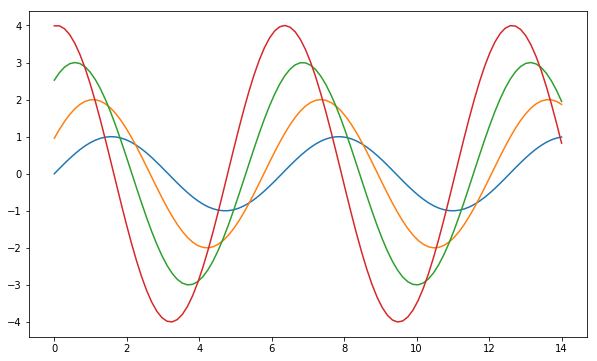

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


x = np.linspace(0, 14, 100)
y1 = np.sin(x)
y2 = 2*np.sin(x+0.5)
y3 = 3*np.sin(x+1.0)
y4 = 4*np.sin(x+1.5)

plt.figure(figsize=(10,6))
plt.plot(x,y1, x,y2, x,y3, x,y4)
plt.show()

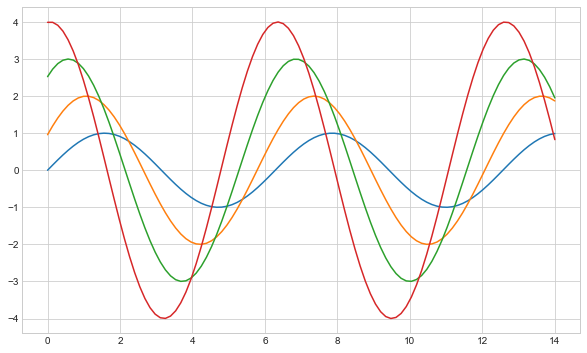

In [41]:
# whitegrid 스타일도 지원

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))
plt.plot(x,y1, x,y2, x,y3, x,y4)
plt.show()

In [42]:
# Seaborn은 연습할 만한 데이터셋을 몇개 가지고 있음

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sns.set_style("whitegrid")
%matplotlib inline

In [43]:
# 요일별 점심, 저녁, 흡연 여부와 식사 금액과 팀을 정리한 데이터 셋
tips = sns.load_dataset("tips")
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


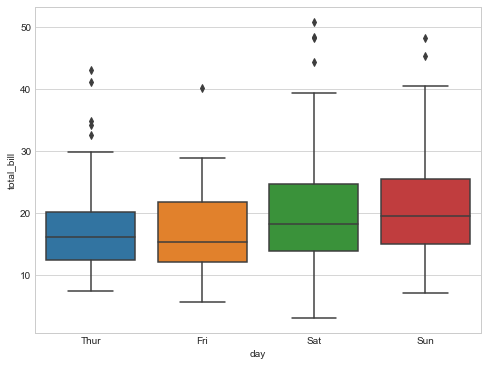

In [44]:
# boxplot를 그리는데 x축에는 요일, y축에는 전체 금액을 그릴 수 있음

plt.figure(figsize=(8,6))
sns.boxplot(x='day', y='total_bill', data=tips)
plt.show()

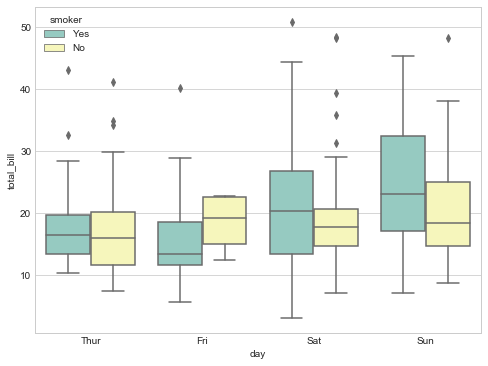

In [45]:
# hue 옵션을 이용해서 구분을 할 수 있음
# 흡연 여부로 구분

plt.figure(figsize=(8,6))
sns.boxplot(x='day', y='total_bill', hue='smoker', data=tips, palette='Set3')
plt.show()

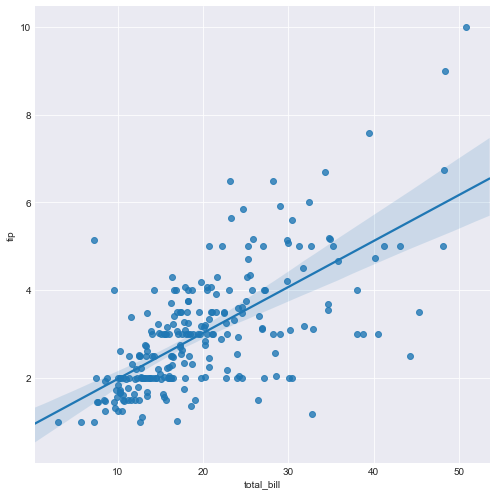

In [46]:
# darkgrid 스타일
# 데이터를 scatter처럼, 직선으로 regression한 그림도 같이 그려주고 유효범위도 ci로 잡아줌
sns.set_style('darkgrid')
sns.lmplot(x='total_bill', y='tip', data=tips, size=7)
plt.show()

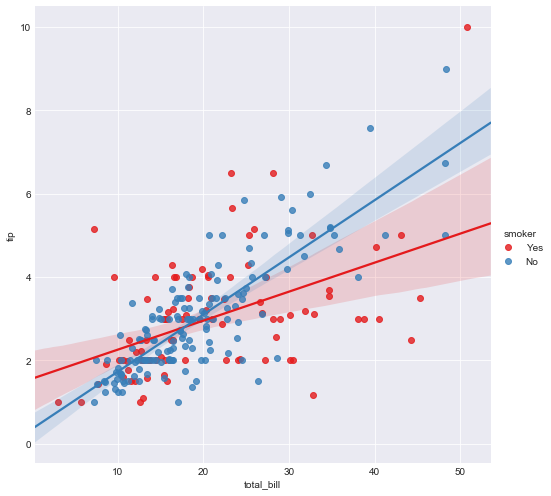

In [47]:
# lmplot도 hue 옵션을 가질 수 있음.
# 미리 준비된 palette로 색상을 지정할 수 있음

sns.lmplot(x='total_bill', y='tip', hue='smoker', data=tips, palette='Set1', size=7)
plt.show()

In [48]:
# 연도 및 월별 항공기 승객수를 기록한 데이터

flights = sns.load_dataset('flights')
flights.head(5)

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [50]:
# pivot 기능으로 간편하게 월별, 연도별로 구분 가능.
flights = flights.pivot('month', 'year', 'passengers')
flights.head(5)

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472


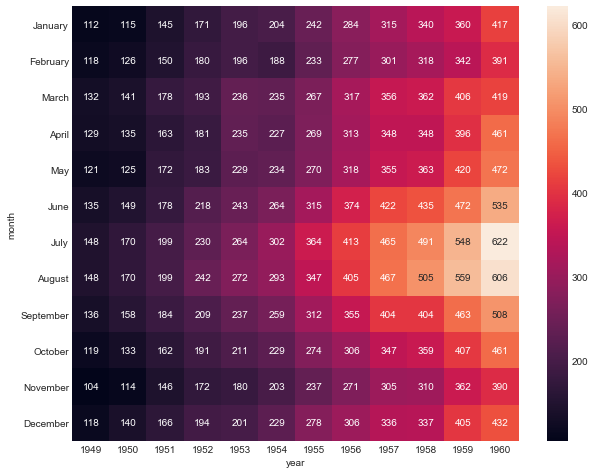

In [51]:
# heatmap을 사용하면 이런 종류의 데이터를 그 경향을 설명하기 좋음

plt.figure(figsize=(10,8))
sns.heatmap(flights, annot=True, fmt='d')
plt.show()

In [52]:
# 머신러닝에서 다뤄지는 아이리스 꼿에 대한 데이터
# 꽃잎, 꽃받침의 너비와 폭을 가지고 그 종을 구분

sns.set(style='ticks')
iris = sns.load_dataset('iris')
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


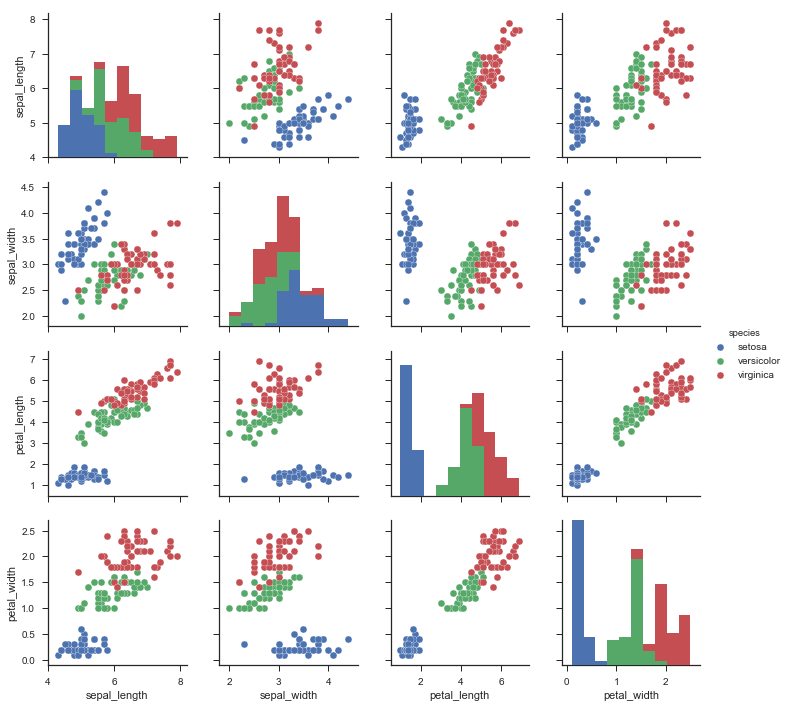

In [53]:
# pairplot
sns.pairplot(iris, hue='species')
plt.show()